In [ ]:
# --- Célula 1: Imports e Configurações ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import shap

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

cols_dict = {
    'track_id': 'Track ID', 'artists': 'Artists', 'album_name': 'Album Name',
    'track_name': 'Track Name', 'popularity': 'Popularity', 'duration_ms': 'Duration (ms)',
    'explicit': 'Explicit', 'danceability': 'Danceability', 'energy': 'Energy',
    'key': 'Key', 'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
    'time_signature': 'Time Signature', 'track_genre': 'Track Genre'
}

In [ ]:
# --- Célula 2: Carregamento dos Dados ---
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv', index_col=0)
# Remova colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]
if 'track_genre' not in df.columns:
    df['track_genre'] = 'unknown'

num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Remova qualquer coluna extra
df = df[num_features + ['track_genre']].copy()


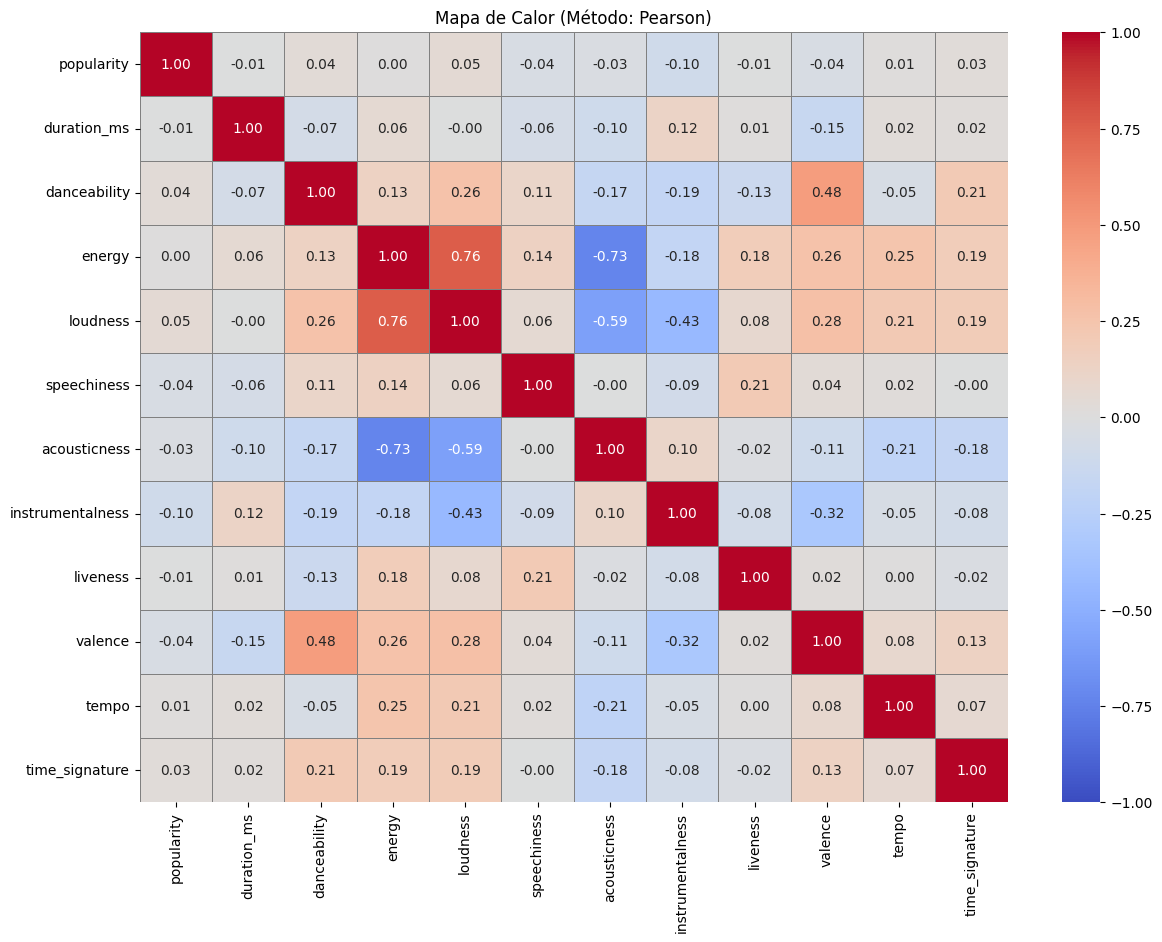

energy    loudness        0.761690
          acousticness   -0.733906
loudness  acousticness   -0.589803
dtype: float64

In [ ]:
# --- Célula 8: Correlação ---
corr_method = "pearson"
corr_matrix = df[num_features].corr(method=corr_method)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title(f"Mapa de Calor (Método: {corr_method.capitalize()})")
plt.show()

# Pares com maior correlação
mask_table = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_unstacked = corr_matrix.where(mask_table).stack()
strong_pairs = corr_unstacked[abs(corr_unstacked) > 0.5].sort_values(key=abs, ascending=False)
display(strong_pairs)

Detectados 5695 outliers.


,track_genre,danceability,energy,loudness,acousticness,valence
17,acoustic,0.7950,0.0841,-18.090,0.742,0.6090
116,acoustic,0.5650,0.0392,-28.276,0.835,0.6010
117,acoustic,0.6640,0.0755,-19.836,0.910,0.5750
270,acoustic,0.6180,0.0830,-23.665,0.745,0.5970
284,acoustic,0.7340,0.0423,-24.831,0.916,0.1400
...,...,...,...,...,...,...
113977,world-music,0.0672,0.0903,-23.496,0.970,0.0361
113979,world-music,0.4170,0.9670,-27.146,0.924,0.0147
113986,world-music,0.1980,0.2570,-17.361,0.968,0.0381
113995,world-music,0.1720,0.2350,-16.393,0.640,0.0339


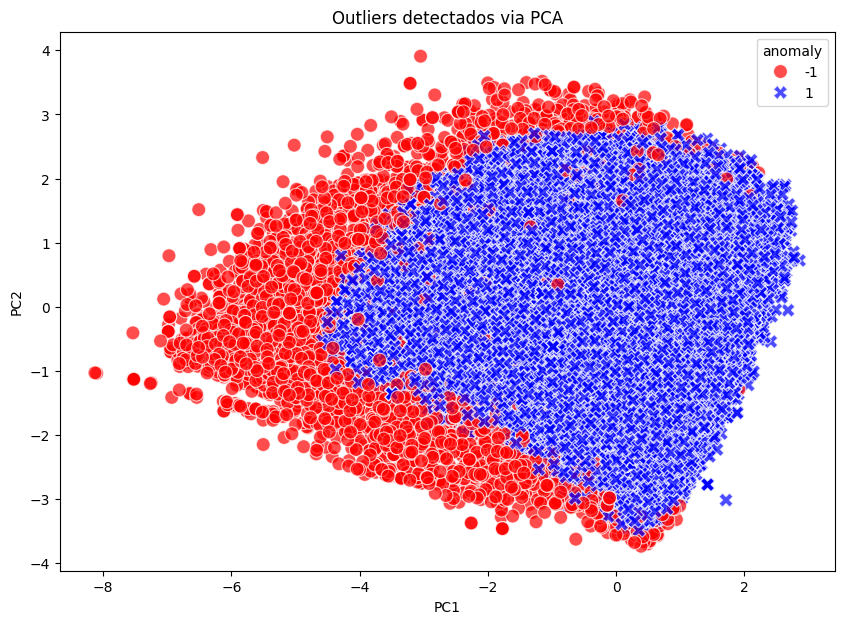

In [ ]:
# --- Célula 9: Detecção de Outliers com Isolation Forest ---
features_for_outliers = ['danceability', 'energy', 'loudness', 'acousticness', 'valence']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_outliers])
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)
outliers = df[df['anomaly'] == -1]
print(f"Detectados {len(outliers)} outliers.")
display(outliers[['track_genre'] + features_for_outliers])

# Visualização PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['anomaly'] = df['anomaly']
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='anomaly', palette={1: 'blue', -1: 'red'}, style='anomaly', s=100, alpha=0.7)
plt.title("Outliers detectados via PCA")
plt.show()

#remoção
df_no_outliers = df[df['anomaly'] != -1].copy()


In [ ]:
# --- Célula 10: Pré-processamento dos Dados ---
df_processed = df_no_outliers.copy()
# Imputação pela mediana
df_processed[num_features] = df_processed[num_features].fillna(df_processed[num_features].median())
# Padronização
scaler = StandardScaler()
df_processed[num_features] = scaler.fit_transform(df_processed[num_features])

display(df_processed.head())

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,anomaly
0,1.766553,0.021907,0.608957,-0.875945,0.217634,0.553016,-0.820430,-0.459803,0.761091,0.907196,-1.202979,0.211623,acoustic,1
1,0.962068,-0.774264,-0.980838,-2.154337,-2.637652,-0.083566,1.995760,-0.459787,-0.599020,-0.874659,-1.559191,0.211623,acoustic,1
2,1.051456,-0.172971,-0.869056,-1.317965,-0.595751,-0.280171,-0.258961,-0.459806,-0.514344,-1.459330,-1.598713,0.211623,acoustic,1
3,1.677166,-0.260322,-1.937200,-2.615424,-2.986090,-0.465324,1.935760,-0.459555,-0.434960,-1.367850,2.001937,-2.433478,acoustic,1
4,2.168795,-0.290575,0.248769,-0.953949,-0.581323,-0.309757,0.558928,-0.459806,-0.694810,-1.272394,-0.108792,0.211623,acoustic,1


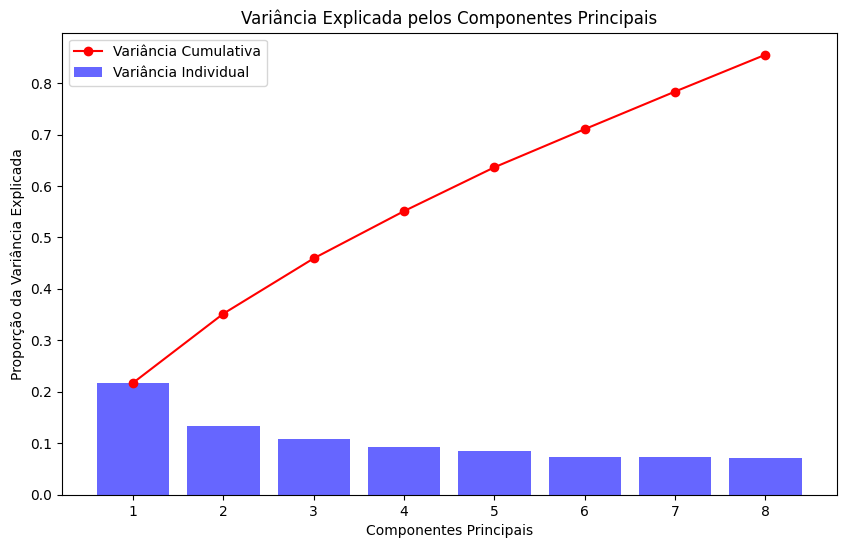

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,0.353681,1.269035,0.212703,0.571542,1.883711,-0.199456,-0.667455,-0.064762
1,-4.122858,0.843727,0.244566,1.011264,1.018950,0.118852,0.635354,-0.723227
2,-1.610035,-0.380814,-0.268018,1.138156,1.334228,-0.724900,0.253461,-1.260689
3,-4.612118,-1.249699,1.367787,2.659527,-1.134707,1.492935,-1.202030,0.937881
4,-1.332805,0.123873,-0.510839,1.896623,1.260242,0.763036,-0.481671,-0.589435


In [ ]:
# --- Célula 11: Redução de Dimensionalidade (PCA) (sem outliers) ---
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_processed[num_features])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.6, color='b', label='Variância Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', label='Variância Cumulativa')
plt.xlabel('Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1))
plt.show()

df_pca = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)], index=df_processed.index)
display(df_pca.head())


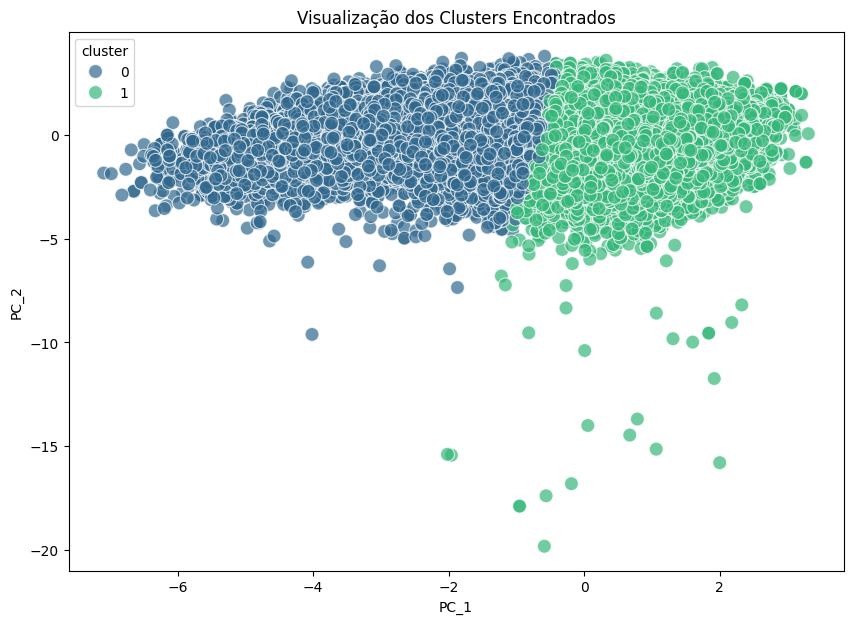

In [ ]:
# --- Célula 12: Clusterização ---
k = 2
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Visualização dos Clusters Encontrados")
plt.show()

In [ ]:
# --- Célula 13: Avaliação dos Clusters ---
silhouette_avg = silhouette_score(df_pca.iloc[:, :-1], labels)
davies_bouldin = davies_bouldin_score(df_pca.iloc[:, :-1], labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

Silhouette Score: 0.222
Davies-Bouldin Score: 1.838


df_shap.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
num_features: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_shap[num_features].shape: (114000, 12)
X_train.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X_train.shape: (114000, 12)
model_rf.n_features_in_: 12
shap_values[0].shape: (12, 114)


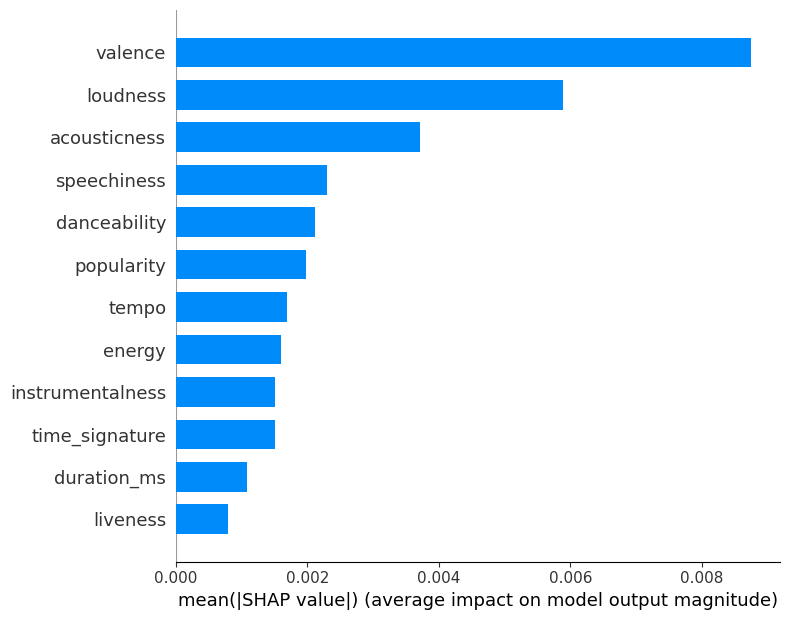

In [ ]:
# --- Célula 14: Interpretação SHAP ---
num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
df_shap = df[num_features + ['track_genre']].copy()

print("df_shap.columns:", list(df_shap.columns))
print("num_features:", num_features)
print("df_shap[num_features].shape:", df_shap[num_features].shape)

X_train = df_shap[num_features].copy()
y_train = df_shap['track_genre']

print("X_train.columns:", list(X_train.columns))
print("X_train.shape:", X_train.shape)

X_sample = X_train.sample(n=12, random_state=42) if len(X_train) > 12 else X_train

model_rf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("model_rf.n_features_in_:", model_rf.n_features_in_)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_sample)
print("shap_values[0].shape:", shap_values[0].shape)
shap.summary_plot(shap_values[0][:, :X_sample.shape[1]], X_sample, plot_type="bar")

In [ ]:
# --- Célula: Classificação com Balanceamento, Cross-Validation e Métricas ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# 1. Separação de features e target
X = df_processed[num_features]
y = df_no_outliers['track_genre']

# 2. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Limite para, por exemplo, 10.000 amostras (ajuste conforme necessário)
max_samples = 10000

if X_bal.shape[0] > max_samples:
    X_bal, y_bal = resample(X_bal, y_bal, n_samples=max_samples, random_state=42, stratify=y_bal)

# 3. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# 4. Treinamento e avaliação de dois modelos
models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\nModelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Acurácia teste:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy')
    print("CV Accuracy média:", np.mean(cv_scores), "Desvio:", np.std(cv_scores))

# Discussão de overfitting:
# Compare a acurácia de treino, teste e cross-validation para cada modelo.


Modelo: RandomForest
Acurácia teste: 0.3125
Classification Report:
                    precision    recall  f1-score   support

         acoustic       0.33      0.18      0.23        17
         afrobeat       0.32      0.65      0.43        17
         alt-rock       0.00      0.00      0.00        17
      alternative       0.28      0.28      0.28        18
          ambient       0.31      0.56      0.40        18
            anime       0.21      0.17      0.19        18
      black-metal       0.42      0.47      0.44        17
        bluegrass       0.42      0.44      0.43        18
            blues       0.27      0.17      0.21        18
           brazil       0.29      0.22      0.25        18
        breakbeat       0.57      0.44      0.50        18
          british       0.40      0.11      0.17        18
         cantopop       0.26      0.29      0.28        17
    chicago-house       0.39      0.41      0.40        17
         children       0.29      0.41      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CV Accuracy média: 0.1791006035216599 Desvio: 0.00492068286711455


In [ ]:
# --- Célula: Regressão com Cross-Validation e Métricas ---
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Exemplo: prever 'popularity' (ou outra variável numérica)
target_reg = 'popularity'
X_reg = df_processed[[col for col in num_features if col != target_reg]]
y_reg = df_no_outliers[target_reg]

# Divisão treino/teste
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Modelos de regressão
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, reg in regressors.items():
    print(f"\nModelo: {name}")
    reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = reg.predict(X_test_reg)
    print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
    print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
    print("R2:", r2_score(y_test_reg, y_pred_reg))

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(reg, X_reg, y_reg, cv=kf, scoring='r2')
    print("CV R2 média:", np.mean(cv_scores), "Desvio:", np.std(cv_scores))


Modelo: LinearRegression
MSE: 491.59054234670634
MAE: 18.449070520081868
R2: 0.02573729070110009
CV R2 média: 0.02397291894359608 Desvio: 0.0013359248468562091

Modelo: Ridge
MSE: 491.59056045440906
MAE: 18.44907687821309
R2: 0.025737254814202304
CV R2 média: 0.0239729253720111 Desvio: 0.0013358975951245715

Modelo: RandomForestRegressor
MSE: 231.81428563385816
MAE: 10.715884732721475
R2: 0.5405769751026925
